# Homework 4

Please complete exercises 7.2, 7.3, 7.4, 7.6, 7.8 in Chapter 7 and 9.2 in Chapter 9 in your
textbook.

In [36]:
import sympy as sym
import autograd.numpy as np
import matplotlib.pyplot as plt

# import autograd ’s automatic differentiator
import autograd as ag

# datapath to data
datapath = '/home/michaelrencheck/EE475/machine_learning_refined-gh-pages/mlrefined_exercises/ed_2/mlrefined_datasets/superlearn_datasets/'

sym.init_printing()

# Standard Normalize the data
def std_normalize(in_arr):
    u = np.mean(in_arr, axis=1)
    sig = np.std(in_arr, axis=1)
        
    out = np.zeros(in_arr.shape)
    
    for i, row in enumerate(in_arr):       
        for j, element in enumerate(row):
            out[i,j] = (element - u[i])/ sig[i]
            
    return np.squeeze(out)

## Problem 7.2

In [58]:
# load in dataset
csvname = datapath + '4class_data.csv'
data = np.loadtxt(csvname,delimiter = ',');

# get input/output pairs
x = data[:-1,:]
y = data[-1:,:] 

x = std_normalize(x)

print(np.shape(x))
print(np.shape(y))

(2, 40)
(1, 40)


In [59]:
def softmax(x,w,y):
    """
    x and w are column vectors
    y is a scalar
    """
    exponent = np.dot(-y, np.dot(x.transpose(),w))
    
    total = np.log(1 + np.exp(exponent))
    
    return total

def grad_softmax(x,w,y):
    """
    x and w are column vectors
    y is a scalar
    """
    
    exponent = np.squeeze(-y *  np.dot(x.transpose(), w))
        
    num = np.exp(exponent)
    denom = 1 + np.exp(exponent)
    
    total = (num/denom) * y * x
    
    return total

def hess_softmax(x, w, y):
        
    exponent = np.squeeze(y *  np.dot(x.transpose(), w))
        
    sigma = 1 / (1 +  np.exp(exponent))
    hess = sigma * (1-sigma) * np.dot(x,x.transpose())
    
    return hess


def newtons(f, df, ddf, x, y, w_init, beta, n=5, normalizer=-1.0):
        
    w = np.copy(w_init)
    
    cost_history = []
    res_history = []

    i = 0

    done = False

    while(not done):

        grad_res = np.zeros([x.shape[0]+1, 1])
        hess_res = np.zeros([x.shape[0]+1, x.shape[0]+1])
        
        cost = 0
        res = 0
        
        for j, yp in enumerate(y[0]): # for each data point

            xp = np.concatenate((np.array([1.0]), x[:,j])) # append a 1
            xp = np.reshape(xp, [len(xp), 1]) # make into a column

            cost += beta[j] * f(xp, w, yp)
            grad_res += beta[j] * df(xp, w, yp)
            hess_res += beta[j] * ddf(xp, w, yp)
            
            y_pred = np.sign(np.dot(xp.transpose(),w))
            
            if (y_pred == 0):
                pass
            else:
                res += (y_pred != yp)
            
        cost /= float(y.shape[1])
        grad_res /= (normalizer * float(y.shape[1]))
        hess_res /= (-normalizer * float(y.shape[1]))
        
        cost_history.append(np.copy(np.squeeze(cost)))
        res_history.append(np.copy(np.squeeze(res)))

        if(i > n):
            done = True
        else:
            
            inv_h_res = np.linalg.inv(hess_res)
            w -= np.dot(inv_h_res, grad_res)
            i += 1
        
    return w, cost_history, res_history

The trained weights using the softmax: 
[[-0.62303075 -0.62829652 -0.63361567 -0.63252296]
 [-0.59987291  0.51650041 -0.50081835  0.59122823]
 [ 0.50198126  0.58178244 -0.58967123 -0.50036375]]
Number of missclassifications:  10.0


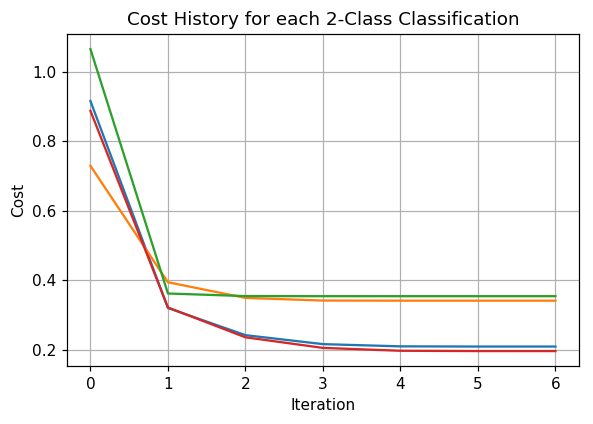

In [69]:
C = 4

w_init = np.ones([x.shape[0]+1, C])*0.5

beta = np.ones(x.shape[1])

yi = np.copy(y)
w_c = np.copy(w_init)

fig1 = plt.figure(dpi=110,facecolor='w')

for i in range(C):
    
    # set y values to +/- 1 based on  the current C
    yi = np.copy(y)
    yi[yi != i] = -1
    yi[yi == i] = 1
    
    out, costs, res = newtons(softmax, grad_softmax, hess_softmax, x, yi, w_init[:,0].reshape(x.shape[0]+1,1), beta, n = 5)
    
    plt.plot(np.arange(len(costs)),costs)
    
    # Normalize w
    out_norm = out/np.linalg.norm(out,2)
    
    w_c[:,i] = np.copy(np.squeeze(out_norm))
    
# Now test the weights using the normalized w's
xp = np.vstack([np.ones(x.shape[1]), x])
test = np.dot(xp.T, w_c)
misclass = test.argmax(axis=1)


        
print("The trained weights using the softmax: ")
print(w_c)

print("Number of missclassifications: ", np.mean(misclass != y) * y.shape[1])

plt.grid(True)
plt.title("Cost History for each 2-Class Classification")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

## Problem 7.3

In [48]:
# load in dataset
data = np.loadtxt(datapath + '3class_data.csv',delimiter = ',')

# get input/output pairs
x = data[:-1,:]
y = data[-1:,:]

x = std_normalize(x)

x = np.vstack([np.ones(x.shape[1]),x])

print(np.shape(x))
print(np.shape(y))


(3, 30)
(1, 30)


In [55]:
def multiclass_perceptron(wi):
    
    W = np.copy(wi)
    
    # pre - compute predictions on all points
    all_evals = np.dot(x.T, W)   
    all_evals = all_evals.T

    # find the max xp.T * w_j for each data point
    a = np.max(all_evals, axis = 0)   

    # Finds xp.T * w_yp for each data point based on the output associated to each input
    # compute cost in compact form using numpy broadcasting
    b = all_evals[y.astype(int).flatten(), np.arange(np.size(y))]
    
    # return average
    return np.sum(a - b) / float(np.size(y))

def grad_descent(func, alpha, n, w0):
    dfunc = ag.jacobian(func)
    
    w = np.copy(w0)
    
    weight_history = [w] # weight history container
    cost_history = [func(w)] # cost function history container
    
    for i in range(n):
        grad_res = dfunc(w)
        w -= alpha * grad_res
        
        weight_history.append(w)
        cost_history.append(func(w))
        
    return weight_history, cost_history, w

df = ag.grad(multiclass_perceptron)

In [56]:
w_init = np.ones([x.shape[0], x.shape[0]])

test = multiclass_perceptron(w_init)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


In [56]:
n = 20
alpha = 0.1

w_init = np.ones([x.shape[0], x.shape[0]])

w_hist, c_hist, wfin = grad_descent(multiclass_perceptron, alpha, n, w_init)

In [57]:
# Combine the labels using fusion rule
test = np.dot(x.T, wfin)

misclass = test.argmax(axis=1)

print("Number of missclassifications: ", np.mean(misclass != y) * y.shape[1])

Number of missclassifications:  0.0


## Problem 7.4

Starting at the final general equation:

$$W = w_0,...,w_{C-1}$$

$$ g(W) = \frac{1}{P}\sum_{p=1}^P max(0, x_p^T(w_j - w_{y_p}); {where {j= 0,...,C-1 and j \ne y_p} }$$

This equation also holds for the two-class classification problem where we only are solving for one set of weights that defines the boundary.

By setting C = 2, we can see that there remains only two components to W, $w_0$ and $w_1$. One of these will be equal to $w_{y_p}$ leaving the max function with only one remaining $w$ to compare against the 0.

In equation 6.33 from the text, the input to $g(*)$ is only a single $w$. For the general solution above, using $w_0$ vs. $w_1$ would yield inverse results of each other so depending on which class we want to define as the positive side of the line, we only need one to select of them to perform the classification because a single line is all that is needed to define the boundary between two classes. 

The other difference between the general solution and equation 6.33 is the  $-y_p$ term. In the general solution, it is assumes that for each point $x_p$ the contents of $w_j$ and $w_yp$ flip $w$ that yields the largest $x_p^Tw_j$. Because $x_p^Tw_y \gt x_p^Tw_j$ we know that if x_p is classified correctly, the cost will be 0 and some positive if it is classified incorrectly by the boundary. But it we only wanted to use one $w$ we would need to determine if a point on the negative side of the line was classified properly. This is where the $-y_p$ term comes into play.

For a two-class problem using a perceptron, the labels are either +1 or -1, meaning that by multiplying by that -y_p value will result in a cost of 0 if the point is classified properly and some positive value if it is classified incorrectly.

Therefore the equation is 6.33 is a special case of the general equation in 7.20.


## Probelm 7.6

Finish the argument started in Section 7.3.7 to show that the multi-class Softmax
cost in Equation (7.23) reduces to the two-class Softmax cost in Equation (6.34).

Starting a the final general equation (7.23):

$$ g(W) = \frac{1}{P}\sum_{p=1}^P \log{ \left( \sum_{j=0}^{C-1} e^{x_p^Tw_j} \right)} - x_p^Tw_{y_p}$$

For the two-class classification case C = 2, by plugging this in and unsimplifying the log the general equation can be rewritten like:

$$ g(w_0, w_1) = \frac{1}{P}\sum_{p=1}^P \log \left( e^{x_p^T(w_j - w_{y_p})} + 1 \right) $$

Where $w_yp$ is either $w_0$ or $w_1$ depending on $x_p$ and $w_j$ is the other column of $W$ that is not $w_{y_p}$.

This form is similar to equation 6.37 and we can apply similar logic as the perceptron when comparing the general equation for C = 2 and the two-class specific equation. Only one of the two columns in $W$ is needed to perform the classification. By selecting one of them, we define the positive side of the boundary. Now we need make sure that sign of $x_p^T w$ has the correct sign. This is where the $-y_p$ comes in to properly adjust for a correct/incorrect classifcation of a -1/+1 output.

## Problem 7.8

Show that the multi-class Perceptron and Softmax costs are always convex
(regardless of the dataset used). To do this you can use, e.g., the zero-order
definition of convexity (see Exercise 5.8).

The zero-order definition of convexity states that:
    $$ g(\lambda w_1 + (1-\lambda)w_2) \leq \lambda g(w_1) + (1-\lambda)g(w_2) $$
    
Meaning that the value of g evaluated at some proportional combination of w's is less than or equal to the proportional combination of $g(w_1)$ and $g(w_2)$.

For a multiclass perceptron/softmax, this relationship must hold between all classes. The multiclass examples are really just various combinations of two-class problems, so if the two-class perceptron/softmax is convex then this property will also extend to a C-class problem.

For a given point, it will have an associated $w_{y_p}$ and when classified properly the cost associated to that data point will be 0 since $w_{y_p} \gt w_{j}$, This will result in a flat hyperplane. If the point is classified incorrectly the cost will always be a positve value that increases as the difference between $w_{y_p}$ and $w_{j}$ increases. This will be represented as a hyperplane with a positive slope that completely surrounds the hyperplane at 0. The cost at some proportional combination of w's will be less than or equal to the proportional cost at the the different w's.

Since the softmax is just a smoothed version of the perceptron the same properties will transfer to this function with the addition trait that is is always continuous.

## Problem 9.2

In [58]:
from sklearn.datasets import fetch_openml
# import MNIST
x, y = fetch_openml('mnist_784', version=1, return_X_y=True)

# re-shape input/output data
x = x.T
y = np.array([int(v) for v in y])[np.newaxis,:]

print(np.shape(x))
print(np.shape(y))

(784, 70000)
(1, 70000)


In [123]:
# normalize each picture
for i in range(x.shape[1]):
    x[:,i] = x[:,i] / np.linalg.norm(x[:,i])

trainingx = x[:,0:50000]
trainingy = y[:,0:50000]

testingx = x[:,50000:]
testingy = y[:,50000:]

# Preappend the ones to the data sets:
trainingx = np.vstack([np.ones(trainingx.shape[1]),trainingx])
testingx = np.vstack([np.ones(testingx.shape[1]),testingx])

print(np.shape(trainingx))
print(np.shape(trainingy))

print(np.shape(testingx))
print(np.shape(testingy))

(785, 50000)
(1, 50000)
(785, 20000)
(1, 20000)


In [155]:
def multiclass_softmax(wi, xin, yin):
    
    # compute predictions on all points
    all_evals = np.dot(xin.T, wi)   
    all_evals = all_evals.T
    
    # Finds xp.T * w_yp for each data point based on the output associated to each input
    b = all_evals[yin.astype(int).flatten(), np.arange(np.size(yin))]

    # subtract the xp.T*w_yp value from all xp.T * w_j values
    # find the max xp.T * w_j for each data point    
    a = (all_evals - b)

    # take the exponent of each xp.T (w_j - w_yp)
    a = np.exp(a)   
    
    # sum each column
    a_sum = a.sum(axis=0)
    
    # take the log of 1+sum for each data point
    a_sum = np.log(1 + a_sum)
    
    # return the average cost
    return np.sum(a_sum) / float(np.size(yin))

def mini_batch_gd(func, w0, data_x, data_y, epochs, alpha, mini_batch_size):
    """
    func- cost function
    w0 - initial guess
    data_x - training data with a 1 already appended to it
    data_y - training data
    epochs - number of full iterations
    alpah - learning rate
    mini_batch_size - the size of each batch to parse the data with
    
    The mini batch size should fit evenly in to the number of data points
    """
    dfunc = ag.grad(func)
    
    w = np.copy(w0)
    
    weight_history = [np.copy(w)] # weight history container
    cost_history = [func(w,data_x,data_y)] # cost function history container
    
    miss_history = []
    
    num_batches = int(data_y.shape[1]/mini_batch_size)
    
    for i in range(epochs):
        
        # Use mini batches to compute each w and cost
        for j in range(num_batches-1):
                        
            x_seg = data_x[:, mini_batch_size * (j) : mini_batch_size * (j+1)]
            y_seg = data_y[:, mini_batch_size * (j) : mini_batch_size * (j+1)]
            
            grad_res = dfunc(w, x_seg, y_seg)
                       
            w -= alpha*grad_res
        
        cost_history.append(func(w, data_x, data_y))
        weight_history.append(np.copy(w))
        
        test = np.dot(data_x.T, w)
        misclass = test.argmax(axis=1)
        miss_history.append(np.sum(misclass != trainingy[0]))        
        print("Completed Epoch: ", i)
        
    return cost_history, weight_history, miss_history, w
    
epochs = 20
alpha = 2e-1
batch_n = 200

C = 10 # numbers 0 through 9

w_init = np.ones([trainingx.shape[0], C])

In [156]:
cost_raw, ws_raw, misses_raw, w_raw = mini_batch_gd(multiclass_softmax, w_init, trainingx, trainingy, epochs, alpha, batch_n)

Completed Epoch:  0
Completed Epoch:  1
Completed Epoch:  2
Completed Epoch:  3
Completed Epoch:  4
Completed Epoch:  5
Completed Epoch:  6
Completed Epoch:  7
Completed Epoch:  8
Completed Epoch:  9
Completed Epoch:  10
Completed Epoch:  11
Completed Epoch:  12
Completed Epoch:  13
Completed Epoch:  14
Completed Epoch:  15
Completed Epoch:  16
Completed Epoch:  17
Completed Epoch:  18
Completed Epoch:  19


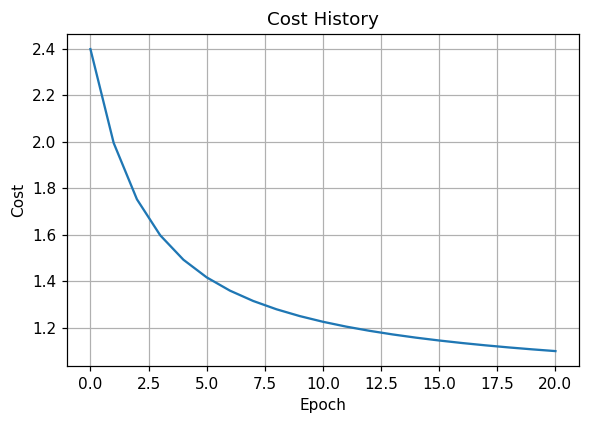

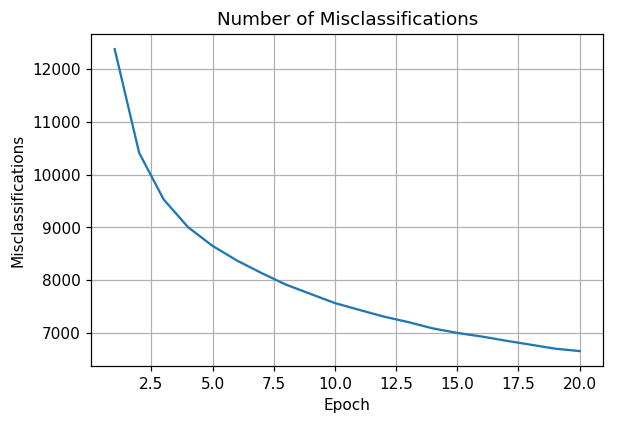

In [160]:

fig1 = plt.figure(dpi=110,facecolor='w')
plt.grid(True)
plt.plot(np.arange(len(cost_raw)),cost_raw)
plt.title("Cost History")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.show()

fig1 = plt.figure(dpi=110,facecolor='w')
plt.grid(True)
plt.plot(np.arange(len(misses_raw))+1,misses_raw)
plt.title("Number of Misclassifications")
plt.xlabel("Epoch")
plt.ylabel("Misclassifications")
plt.show()